## Working with hierarchy keys


A workflow and some code snippets to work with hierarchy key values in a GeMS DMU table.
For those not familiar with Jupyter Notebooks, perhaps the easiest way to use this notebook is to open it ArcGIS Pro.  
Navigate up or down through the cells with the up/down arrow keys on your keyboard or click in the cell to which you want focus changed.  
For markdown cells you need to press Enter on your keyboard to enter edit mode. For python cells, just click to change focus and start writing.  
To run the code in a python cell or save editing in a markdown cell, press Shift-Enter.  
There are four variables you need to edit:  
1. the path to a text file saved from Word; chosen through a file browsing dialog.
2. the path to a DescriptionOfMapUnits table in a GDB. It can be empty, but it needs to exist. Get this path by activating the Map tab, browsing to and selecting the table in the Catalog pane, and then clicking 'Copy Path' from the Clipboard section of the Map menu ribbon.
3. the names of the fields that will be updated in your DMU table.
4. a path to write a text file to for importing into Word  

Look for the comments that begin ``# EDIT THIS VARIABLE...``.

In [ ]:
import arcpy

In [ ]:
def dir_dialog():
    # open a file dialog to choose a .gdb file, which is reported as a path to a file
    from tkinter import Tk
    from tkinter import filedialog
    Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
    dir_path = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file

    return dir_path

### 1. Word to GDB table
1. In MS Word, write a few major heading divisions of the DMU, one line per heading
2. Select everything
2. On the Home tab of the main ribbon, go the Paragraph section and click the drop-down for Multilevel List, and from the List Library select the style that reads: "1 Heading 1, 1.1 Heading 2, 1.1.1 Heading 3"  

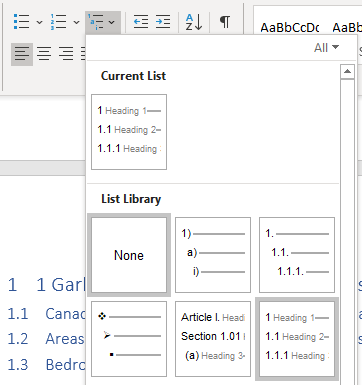

3. Go to the View tab of the main ribbon, go the Views section (far left), and select Outline.
4. Finish your list of map units. Add a pipe character, ```|```, right after the outline number and between all values that are to be inserted into different fields. Be sure to enter your values consistently, eg., if you are only entering three of four possible attributes for a particular line, be sure to include two pipe characters with nothing in between for the empty attribute. Promote, demote, indent, and dedent each line as necessary to display the stratigraphic hierarchy. The numbers in the outline will *usually* get updated automatically as you expect, but it can be finicky. Try deleting a line that is not working and going back to the parent to start again.  
5. For each unit, after the number, write the unique MapUnit value (usually the abbreviation or label) and the Name or Fullname as you like. There might not be much benefit to adding additional attributes at this time. Whether you copy/paste/write values into the Word document or the DMU table once you have it built might not matter.
5. Save the word document as a text file.

Select the text file to save the path in a variable and write the path

In [ ]:
# EDIT THIS VARIABLE BY SELECTING THE FILE IN THE FILE DIALOG
text_file_from_word = dir_dialog()
text_file_from_word

In [ ]:
# we don't need a list of lines for right now; we'll use it in the next step, but it's easy to get here.
lines = []
with open(text_file_from_word, mode='r', encoding='utf-8-sig') as file:
    for line in file.readlines():
        lines.append(line)
        print(line)

### 2. Prepare the text file  
The single integer, non-zero-padded numbers we get from the outline view in Word will not sort properly in a database table. While it is possible to create a multilevel list numbering scheme in Word that uses zero-padded numbers and export that list to a text file, it requires either laboriously setting up the style in Word, or passing around a template Word document that already has the style in it. Also, I have not found a way to take zero-padded numbers from a database table and get them into Word as a multilevel numbered list, even if the Word document has the original style in it. So, we'll scrap that idea and just use some code to either add or remove padding zeros as necessary depending on the direction of the transcription.

#### Zero-padding
In the next step, the single integer parts of the hierarchy key value will be broken apart and then padded with zeros to 3 spaces. Also, each line will be re-written so that the mapunit is first, followed by the hierarchykey and whatever other fields were exported from Word. This is done so that in step 2.2 it will be easier to build a dictionary of the values that will be used with the UpdateCursor.  

**This will overwrite the text that you exported from Word. Make a copy if you are squeamish** (although you can always go back to Word to save the file again)

In [ ]:
new_lines = []
with open(text_file_from_word, mode='w', encoding='utf-8-sig') as file:
    for line in lines:
        vals = [val.strip() for val in line.split("|")]
        mapunit = vals.pop(1)
        if "." in vals[0] or vals[0].isnumeric():
            padded = [str(i).zfill(3) for i in vals[0].split('.')]
            vals[0] = "-".join(padded)
        vals_str = "|".join(vals)
        new_lines.append(f"{mapunit}|{vals_str}")
    file.write("\n".join(new_lines))
    
with open(text_file_from_word, mode='r', encoding='utf-8-sig') as file:
    print(file.read())

### 2.2 Create a python dictionary of the contents of the text file
Read the text file into a python dictionary that consists of entries  
``{mapunit: [mapunit, hierarchykey, name, field_n...]}``  
This will be useful when updating or inserting rows in the DMU in the GDB.  

In [ ]:
update_dict = {}
with open(text_file_from_word, mode='r', encoding='utf-8-sig') as file:
    lines = file.readlines()
    
    # first line has the names of the fields in the order they will be called for the cursors
    #fields_for_cursor = lines[0].strip().split("|")
    
    # the rest of the lines have the values
    for line in lines:
        vals = [v.strip() for v in line.split("|")]
        # first item in the list will be the mapunit
        # that will be our key and the value will be whole list of values
        update_dict[vals[0]] = vals

for k,v in update_dict.items():
    print(f"{k}: {v}")

### 2.3 Update the DMU
Open an UpdateCursor on the DMU.  
Look up each MapUnit in the update dictionary from Step 2.2  
If the MapUnit exists as a key in the udpate dictionary, update that row. 
If the MapUnit can't be found, that means it is a new unit; added when the LMU was edited in Word. Delete that dictionary entry from a copy of the update dictionary and the remainders which will be used with an InsertCursor. It's tricky having two cursors open on a data source at the same time, so we'll run updates first and then inserts. 

In [ ]:
# EDIT THIS VARIABLE AS NEEDED
gems_dmu = r"C:\_AAA\tools\materialized-paths\dmu\Default.gdb\DescriptionOfMapUnits"

In [ ]:
# DO NOT RUN THIS COMMAND UNLESS YOU NEED TO EMPTY THE DMU TABLE.
# I only used it during development and you may not need to use it.

arcpy.management.TruncateTable(gems_dmu)

Make a list variable of the fields that will be updated in the order of the values in the text file. The first two field names should always be ```MapUnit, HierarchyKey``` followed by whatever else you have decided to include, eg ```Name```.

In [ ]:
# EDIT THIS VARIABLE AS NEEDED
fields_for_cursor = ['MapUnit', 'HierarchyKey', 'Name']

The code below is where new rows are inserted and old rows are updated. If you have your DMU table open in ArcGIS Pro as a table view, you might not see these updates when you click on the tab. You will often have to close the table view tab and re-open the table from the Contents pane to see the changes.  

**You will not be able to undo the changes. Make a copy if the table is hard to recreate.**

In [ ]:
insert_dict = update_dict.copy()
# open an Update Cursor and look for mapunits as keys in update_dict
with arcpy.da.UpdateCursor(gems_dmu, fields_for_cursor) as cursor:
    for row in cursor:
        if row[0] in update_dict:
            row = update_dict[row[0]]
            cursor.updateRow(row)
            del insert_dict[row[0]]

# if any entries remain in insert_dict, they need to be inserted with an Insert Cursor
if insert_dict:
    with arcpy.da.InsertCursor(gems_dmu, fields_for_cursor) as cursor:
        for k,v in insert_dict.items():
            print(k, v, len(v))
            cursor.insertRow(v)

### 3 GDB to text interchange file
To go back to Word, we need to make a text file from the DMU table that will be suitable for applying the multilevel numbering list style to it. This means  
1. putting the hierarchy key in the front of each row
2. un-zero-padding the hierarchy key numbers
3. adding pipe characters between field values (only added for convenience)

In [ ]:
# EDIT THIS VARIABLE AS NEEDED
# THE TEXT FILE DOES NOT NEED TO EXSIST
lmu_text = r"C:\_AAA\tools\materialized-paths\demo\lum_text.txt"

In [ ]:
fields_for_export = ['HierarchyKey', 'MapUnit', 'Name']
lmu_list = []
with arcpy.da.SearchCursor(gems_dmu, fields_for_export, sql_clause=(None,'ORDER BY HierarchyKey')) as cursor:
    for row in cursor:
        hkey = row[0]
        hkey_list = [elem.lstrip('0') for elem in hkey.split('-')]
        unpad = '.'.join(hkey_list)
        val_string = f"{unpad} | {' | '.join(row[1:])}"
        lmu_list.append(val_string)
        
with open(lmu_text, 'w') as file:
    file.write('\n'.join(lmu_list))

### 4 Open in Word  
1. open that text file in word
2. select everything
3. go to Home > Paragraph section and select the multilevel list numbering style we used in step 1
4. switch to outline view